In [2]:
# Pytorch Specific Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch

# Plotting
import matplotlib.pyplot as plt

# Data
import numpy as np
import pandas as pd

#Other
import tqdm
import random

from DatasetClass import TrajectoryDatasetTest, TrajectoryDatasetTrain
from models.LSTMModelClass import LSTMModel
from models.LinearRegressionModelClass import LinearRegressionModel
from models.CNNModelClass import CNNModel
from models.MLPModelClass import MLPModel

In [4]:
train_data = np.load('cse-251-b-2025/input/train.npz')['data']
test_data  = np.load('cse-251-b-2025/input/test_input.npz')['data']

X_train = train_data[..., :50, :] # Input (scenes, agents, first 50 timesteps, features)
Y_train = train_data[:, 0, 50:, :2] # Output (scenes, ego car, next 60 timesteps, x/y coordinates)

# Print input and output data shape
print(train_data.shape, test_data.shape)
print(X_train.shape, Y_train.shape)

(10000, 50, 110, 6) (2100, 50, 50, 6)


In [6]:
# Used from midquarter checkpoint for simplicity and consistency
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

device = torch.device('mps')
print("Using Apple Silicon GPU")

Using Apple Silicon GPU


In [59]:
model_type = 'MLP'
match model_type:
    case 'LinearRegression':
        model = LinearRegressionModel().to(device)
    case 'MLP':
        model = MLPModel(6*50, 60 * 2).to(device)
    case 'CNN':
        model = CNNModel().to(device)
    case 'LSTM':
        model = LSTMModel().to(device)

# optimizer
# optimizer = optim.RAdam(model.parameters(), lr=1e-3, weight_decay=1e-6)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)

# scheduler
step = 20
gamma = 0.25
scheduler = optim.lr_scheduler.StepLR(optimizer, step, gamma)


early_stopping_patience = 10
best_val_loss = float('inf')
no_improvement = 0

# Criterion MSE
criterion = nn.MSELoss()

In [ ]:
val_mae_list = []
val_mse_list = []
train_mse_list = []

for epoch in tqdm.tqdm(range(100), desc="Epoch", unit="epoch"):
    # ---- Training ----
    model.train()
    train_loss = 0
    train_mse = 0
    for batch in train_dataloader:
        batch = batch.to(device)
        pred = model(batch)
        y = batch.y.view(batch.num_graphs, 60, 2)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        train_loss += loss.item()
        train_mse += nn.MSELoss()(pred, y).item()
    
    # ---- Validation ----
    model.eval()
    val_loss = 0
    val_mae = 0
    val_mse = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            val_loss += criterion(pred, y).item()

            # show MAE and MSE with unnormalized data
            pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            val_mae += nn.L1Loss()(pred, y).item()
            val_mse += nn.MSELoss()(pred, y).item()
    
    # ---- Logging ----
    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    val_mae /= len(val_dataloader)
    val_mse /= len(val_dataloader)
    train_mse /= len(train_dataloader)
    scheduler.step()

    # Graph metrics
    val_mae_list.append(val_mae)
    val_mse_list.append(val_mse)
    train_mse_list.append(train_mse)
    
    tqdm.tqdm.write(f"Epoch {epoch:03d} | Learning rate {optimizer.param_groups[0]['lr']:.6f} | train normalized MSE {train_loss:8.4f}, | val normalized MSE {val_loss:8.4f}, | train MSE {train_mse:8.4f} |  val MAE {val_mae:8.4f} | val MSE {val_mse:8.4f}")
    if val_loss < best_val_loss - 1e-3:
        best_val_loss = val_loss
        no_improvement = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        no_improvement += 1
        if no_improvement >= early_stopping_patience:
            print("Early stop!")
            break

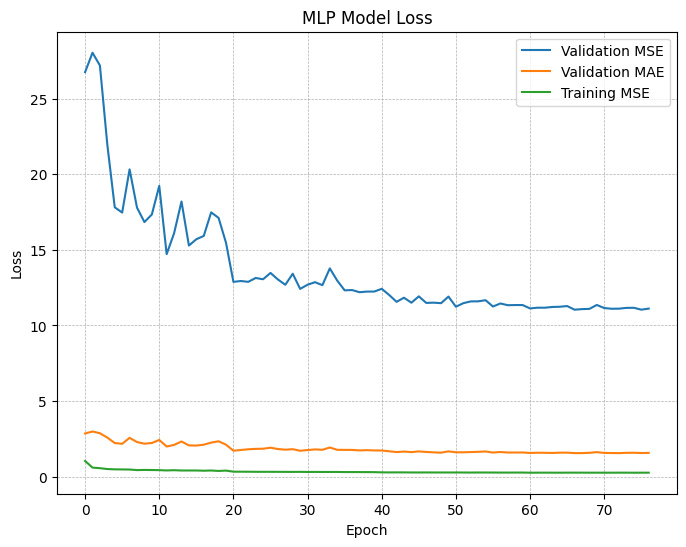

[1.0378894056622863, 0.5975343339303707, 0.5591376159102359, 0.5026851550061652, 0.48193424718177064, 0.4764236294208689, 0.47080709843348106, 0.43210055232576444, 0.4443779258017844, 0.4366711953007583, 0.4298763368146639, 0.40986960021950675, 0.42597712137809035, 0.4057514710312194, 0.40698433572307546, 0.40646766274110646, 0.392021303851131, 0.40571667930335864, 0.3769436652461688, 0.3997969313769053, 0.328722310695031, 0.3263362600395443, 0.32414703055265104, 0.3198333829641342, 0.31830436596316647, 0.3190670303260604, 0.31725271344713285, 0.31542468321978623, 0.3126929871051024, 0.31637895487724466, 0.3099086642899412, 0.3117794116021048, 0.30992609938831195, 0.30866661601772544, 0.30941028869215476, 0.303063654307778, 0.3030247986845091, 0.30145253246346265, 0.30018570126159816, 0.29767314299729697, 0.28262160845259404, 0.2797096732026296, 0.2824540070872358, 0.28086614735583043, 0.27635016598811385, 0.2752299167691393, 0.2782829043237453, 0.2749206670791122, 0.27506375986527887,

In [61]:
# plot MSE and MAE
plt.figure(figsize=(8, 6))
plt.plot(val_mse_list, label='Validation MSE')
plt.plot(val_mae_list, label='Validation MAE')
plt.plot(train_mse_list, label='Training MSE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.yscale('log')
plt.legend()
plt.grid(linestyle = '--', linewidth = 0.5)

plt.title(f'{model_type} Model Loss')

plt.show()
print(train_mse_list)

In [23]:
# Trajectory Plotting, used from midquarter checkpoint

def plot_trajectory(ax, pred, gt, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[0,:60,0], pred[0,:60,1], color='red', label='Predicted Future Trajectory')
    
    # Plot the ground truth future trajectory
    ax.plot(gt[0,:60,0], gt[0,:60,1], color='blue', label='Ground Truth Future Trajectory')
    
    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    if title:
        ax.set_title(title)
    
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

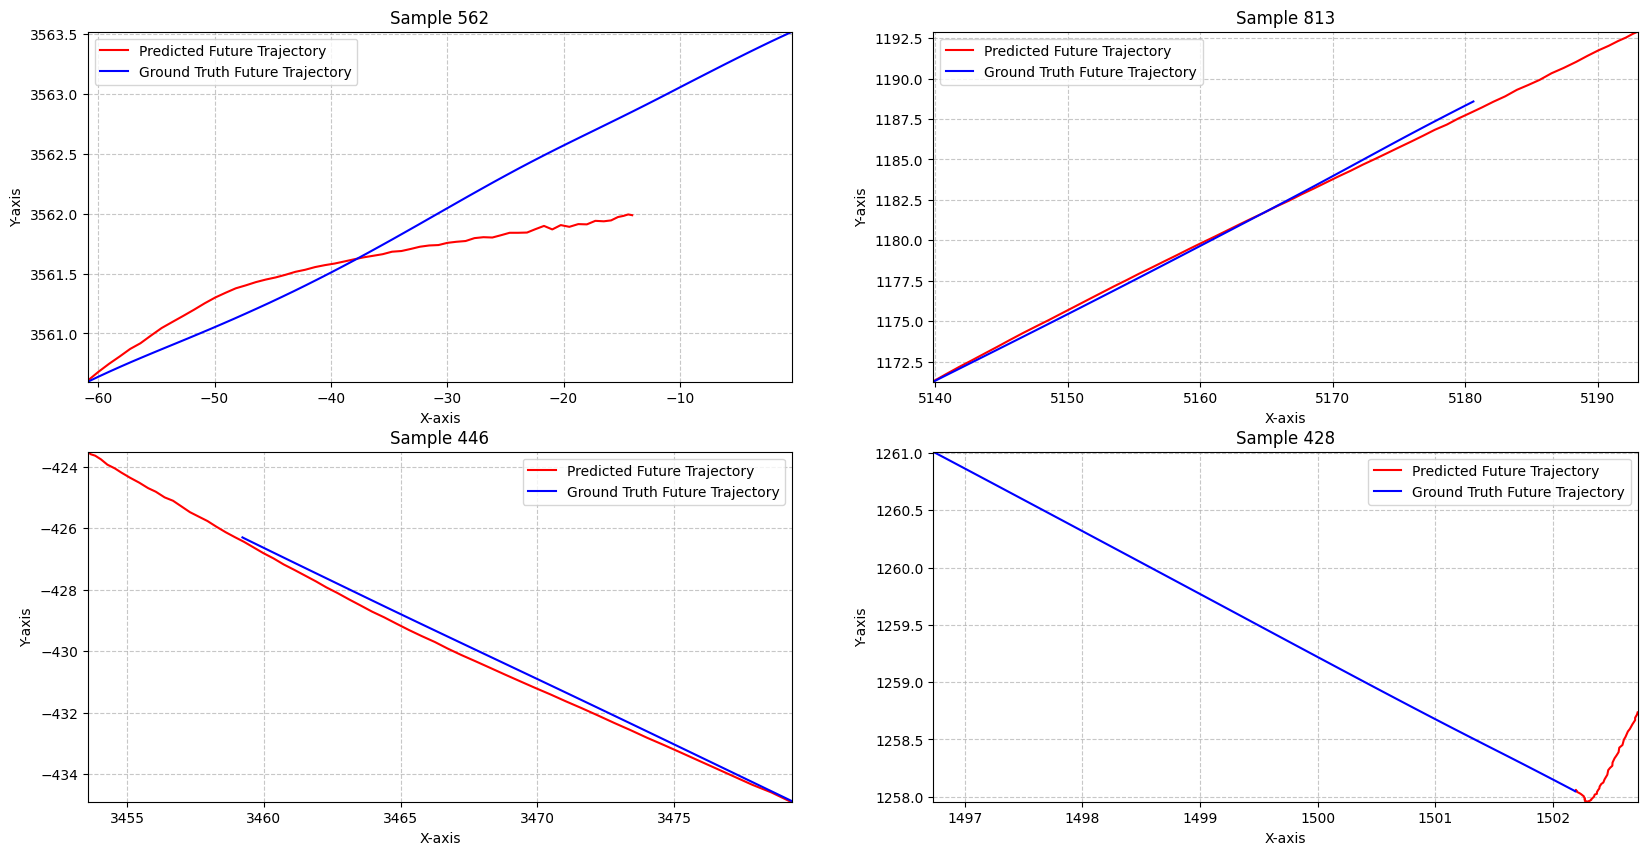

In [32]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# randomly select 4 samples from the validation set
random_indices = random.sample(range(len(val_dataset)), 4)
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()  # Flatten the array to iterate single axes objects

for i, idx in enumerate(random_indices):
    batch = val_dataset[idx]
    batch = batch.to(device)
    pred = model(batch)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0)

    pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0) * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

    pred = pred.detach().cpu().numpy()
    gt = gt.detach().cpu().numpy()

    # Plot the trajectory using the i-th axis
    plot_trajectory(axes[i], pred, gt, title=f"Sample {idx}")

plt.show()

In [33]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model = torch.load("best_model.pt")

model.load_state_dict(best_model)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission.csv', index=True)